In [2]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches


matplotlib.style.use('ggplot')
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

base = './v0.5'

In [3]:
os.chdir('/home/jos/lateral-line/tensorboardlogs/peregrine')
os.getcwd()

'/home/jos/lateral-line/tensorboardlogs/peregrine'

In [4]:
print(os.listdir('./v0.5'))

dfs = []
for path in os.listdir(base):
    for run in os.listdir(os.path.join(base, path)):
        fnm = os.path.join(base, path, run, 'results.csv')
        if not os.path.exists(fnm):
            continue
        df = pd.read_csv(fnm)
        df['model'] = path
        dfs.append(df)

['parallel_dense', 'cross_default', 'tau3', 'best', 'parallel_n01', 'parallel_m3', 'l2', 'no_sharing', 'parallel_m2', 'parallel_n02', 'parallel_multi_range', 'tau2', 'parallel_n0001', 'parallel_m1', 'parallel_default', 'parallel_m5', 'tau4', 'parallel_m0', 'tau1']


In [5]:
df = pd.concat(dfs)

In [6]:
# Get rid of tests
df = df[df['model'] != 'test']

In [7]:
averages = df.groupby(('epoch','model')).mean().reset_index()
stds = df.groupby(('epoch', 'model')).std().reset_index()

In [8]:
avg_pv = averages.pivot(index='epoch', columns='model')

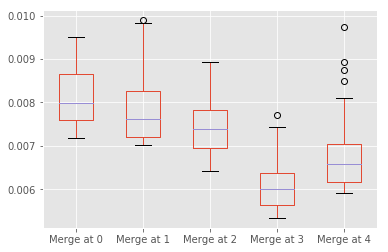

In [25]:
merge_point = avg_pv['mse'][['parallel_m0', 'parallel_m1', 'parallel_m2', 'parallel_m3', 'parallel_default']][200:]
renaming = {'parallel_m0': "Merge at 0", 'parallel_m1': "Merge at 1", 'parallel_m2': "Merge at 2", 'parallel_m3': "Merge at 3", 'parallel_default': "Merge at 4"}
merge_point.rename(columns=renaming, inplace=True)
merge_point.boxplot()

In [9]:
import colorlover as cl
import numpy as np

cs = cl.to_numeric(cl.scales['7']['qual']['Set1'])
cs = np.asarray(cs) / 255.0

In [21]:
from collections import namedtuple

Patch = namedtuple('Patch', 'color label')

def plot_results(df, renaming, title, from_idx=225, xlabel='', rotation=0, figname='plot', colors=None, col='mse', patches=[]):
    fig = plt.figure(figsize=(8, 5))
    subset = df[col][list(renaming.keys())][from_idx:]
    subset.rename(columns=renaming, inplace=True)
    results = list(subset.mean(axis=0).to_dict().values())
    bars = plt.bar(np.arange(len(renaming)), results, yerr=subset.std(axis=0))
    for bar, c in zip(bars, colors):
        bar.set_color(c)
    ax = plt.gca()
    ax.set_xlabel('')
    ax.set_ylabel('MSE')
    ax.set_xticks(np.arange(len(renaming)))
    ax.set_xticklabels(renaming.values(), ha='right')
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=rotation)
    plt.plot([-.5, len(renaming)-0.5], [results[0], results[0]], linestyle='--', color='black', linewidth=1.0)
    plt.title(title)
    plt.ylim([0.002, 0.009])
    
    handles = [mpatches.Patch(color=patch.color, label=patch.label) for patch in patches]
    plt.legend(handles=handles)
    plt.tight_layout()
    plt.savefig(os.path.join('/home/jos/Dropbox/RUG/5e Jaar/latline/paper/bnaic14_style/figures', figname + '.pdf'))

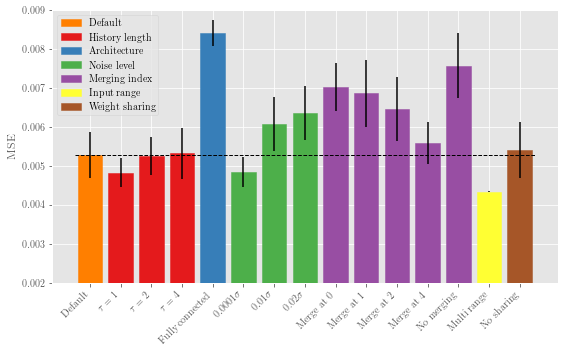

In [22]:
renaming = {
    'tau3': 'Default',
    'tau1': r'$\tau=1$', 
    'tau2': r'$\tau=2$', 
    'tau4': r'$\tau=4$', 
    "cross_default": "Fully connected",
    "parallel_n0001": r"$0.0001\sigma$",
    'parallel_n01': r"$0.01\sigma$", 
    'parallel_n02': r"$0.02\sigma$",
    'parallel_m0': "Merge at 0", 
    'parallel_m1': "Merge at 1", 
    'parallel_m2': "Merge at 2", 
    'parallel_default': "Merge at 4",
    'parallel_m5': "No merging",
    'parallel_multi_range': 'Multi range',
    'no_sharing': "No sharing"
}


plot_results(
    avg_pv, 
    renaming, 
    '', 
    figname='results',
    colors=[cs[4]] + [cs[0]] * 3 + [cs[1]] + [cs[2]] * 3 + [cs[3]] * 5 + [cs[5]] + [cs[6]],
    rotation=45,
    col='mse',
    patches=[
        Patch(cs[4], 'Default'),
        Patch(cs[0], 'History length'),
        Patch(cs[1], 'Architecture'),
        Patch(cs[2], 'Noise level'),
        Patch(cs[3], 'Merging index'),
        Patch(cs[5], 'Input range'),
        Patch(cs[6], 'Weight sharing')
    ]
)

In [37]:
from pandas import DataFrame

subset = avg_pv['mse'][list(renaming.keys())][225:]
subset.rename(columns=renaming, inplace=True)
mean_df = subset.mean(axis=0)
std_df = subset.std(axis=0)

pd.set_option('display.float_format', '{:.2E}'.format)

table_df = DataFrame({'MSE': mean_df, r'$\pm std.$': std_df})
print(table_df[['MSE', r'$\pm std.$']].to_latex())

\begin{tabular}{lrr}
\toprule
{} &      MSE &  \$\textbackslashpm std.\$ \\
model           &          &             \\
\midrule
Default         & 5.28E-03 &    5.99E-04 \\
\$\textbackslashtau=1\$        & 4.83E-03 &    3.71E-04 \\
\$\textbackslashtau=2\$        & 5.25E-03 &    4.90E-04 \\
\$\textbackslashtau=4\$        & 5.33E-03 &    6.57E-04 \\
Fully connected & 8.40E-03 &    3.29E-04 \\
\$0.0001\textbackslashsigma\$  & 4.84E-03 &    3.80E-04 \\
\$0.01\textbackslashsigma\$    & 6.07E-03 &    6.83E-04 \\
\$0.02\textbackslashsigma\$    & 6.35E-03 &    6.91E-04 \\
Merge at 0      & 7.03E-03 &    6.20E-04 \\
Merge at 1      & 6.86E-03 &    8.53E-04 \\
Merge at 2      & 6.46E-03 &    8.29E-04 \\
Merge at 4      & 5.58E-03 &    5.36E-04 \\
No merging      & 7.57E-03 &    8.42E-04 \\
Multi range     & 4.35E-03 &    1.99E-05 \\
No sharing      & 5.41E-03 &    7.09E-04 \\
\bottomrule
\end{tabular}



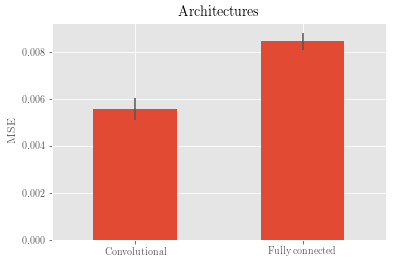

In [47]:
plot_results(avg_pv, {'parallel_default': "Convolutional", "cross_default": "Fully connected"}, 'Architectures', figname='archs')

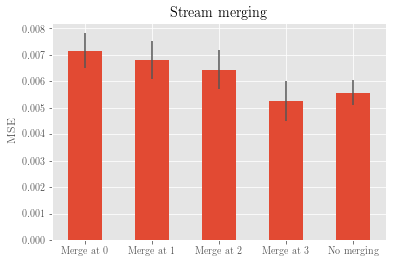

In [48]:
plot_results(avg_pv, {'parallel_m0': "Merge at 0", 'parallel_m1': "Merge at 1", 'parallel_m2': "Merge at 2", 
                      'parallel_m3': "Merge at 3", 'parallel_default': "No merging"}, 'Stream merging', figname='merge')

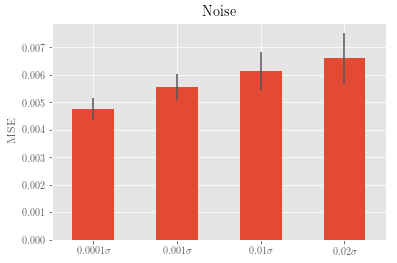

In [49]:
plot_results(avg_pv, {"parallel_n0001": "$0.0001\sigma$", 'parallel_default': "$0.001\sigma$", 
                      'parallel_n01': "$0.01\sigma$", 'parallel_n02': "$0.02\sigma$"}, 'Noise', figname='noise')

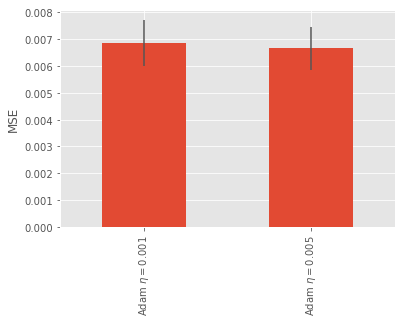

In [11]:
avg_pv.columns
plot_results(avg_pv, {'parallel_default': "Adam $\eta=0.001$", 'adam2': "Adam $\eta=0.005$"}, rotation=90)

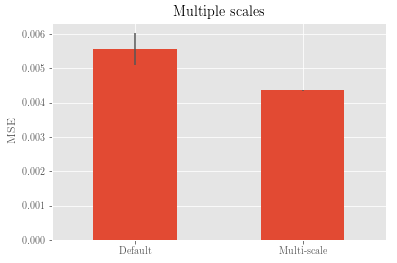

In [51]:
plot_results(avg_pv, {'parallel_default': "Default", 'parallel_multi_range': "Multi-scale"}, 'Multiple scales', figname='scales')

In [13]:
pmr = df[df['model'] == 'parallel_multi_range']

In [15]:
pmr[pmr['epoch'] == 249]['mse'].std()
pmr[pmr['epoch'] == 249]

,epoch,mse,loss,model
249,249,0.004294,189.671,parallel_multi_range
249,249,0.005056,202.950,parallel_multi_range
249,249,0.004580,189.223,parallel_multi_range
249,249,0.004900,193.705,parallel_multi_range
249,249,0.004876,188.716,parallel_multi_range
